## Adaptive GTT GAN
MNISTの実験

In [1]:
import os, glob, copy, time, math
visible_devices = [2,3]
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join([str(i) for i in visible_devices])

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import datasets
import torchvision.transforms as transforms
from pytorch_memlab import MemReporter
from multiprocessing import Pool, cpu_count
from attrdict import AttrDict
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# カレントディレクトリをリポジトリ直下にして自家製モジュールをimport
while os.getcwd().split('/')[-1] != 'schwbert': os.chdir('..')
print('current dir:', os.getcwd())
from utils import Timer, count_params
from modules.multi_gpu import MultiGPUWrapper

core_num = 20
print(f"{core_num}/{cpu_count()} cpus are available.")

current dir: /root/schwbert
20/32 cpus are available.


設定

In [2]:
data_dir = "../datasets/mnist"

In [3]:
config = AttrDict({
    'batch_size': 5000,
    'img_size': 28,
    'lr': 0.0002,
    'b1': 0.5,
    'b2': 0.999,
    'latent_dim': 100,
    'k': 5,
    'max_gtt': 100,
    'fm_lambda': 10,
    'gp_lambda': 10,
})

config.img_shape = (1, config.img_size, config.img_size)

データロード

In [4]:
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        data_dir,
        train=True,
        download=True,
        transform=transforms.Compose(
            # 同サイズ，平均0.5，標準偏差0.5のテンソルへtransform
            [transforms.Resize(config.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=config.batch_size,
    shuffle=True,
)
len(dataloader)

12

確認関数

In [5]:
def show_img(batch, batch_id=0):
    npimg = batch[batch_id].detach().numpy()
    npimg = npimg.reshape((config.img_size, config.img_size))
    plt.imshow(npimg, cmap='gray')

モデル

In [6]:
class Generator(nn.Module):
    def __init__(self, config):
        super(Generator, self).__init__()
        self.img_shape = config.img_shape
        self.latent_dim = config.latent_dim

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(config.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(len(z), *self.img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self, config):
        super(Discriminator, self).__init__()
        self.img_shape = config.img_shape
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(self.img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        ans = self.sigmoid(validity)
        return ans, validity

モデルの準備

In [7]:
device = torch.device('cuda')
multi_gpu = (visible_devices != []) & (device.type == 'cuda')

G = Generator(config).to(device)
D = Discriminator(config).to(device)

# Gの中でノイズ作って，DataParallel通すとGの出力のBatch数がGPUの個数倍になって出てくる謎現象が発生する
# zを外で作って先にdeviceを与えてやったらうまくいった
# てかmultigpuする必要もないほど軽い
multi_gpu = False
if multi_gpu:
    print("Use Multi GPUs")
    G, D = MultiGPUWrapper(G), MultiGPUWrapper(D)

g_optim = optim.Adam(G.parameters(), lr=config.lr, betas=(config.b1, config.b2))
d_optim = optim.Adam(D.parameters(), lr=config.lr, betas=(config.b1, config.b2))

print("Network settings completed")
print("#parameters of G:", count_params(G))
print("#parameters of D:", count_params(D))

Network settings completed
#parameters of G: 1510032
#parameters of D: 533505


訓練関数

In [8]:
def train_gan_adaptive(G, D, g_optim, d_optim, k, max_gtt, fm_lambda, dataloader, epoch_num, device,
              start_epoch=1, clear_disp_epoch_period=3, save_epoch_period=None, get_status_dict=True):
    
    torch.backends.cudnn.benchmark = True
    
    batch_num = len(dataloader)
    batch_size = dataloader.batch_size
    data_size = len(dataloader.dataset) // batch_size
    
    status_dict = { 
        'd_loss': [], 'd_ans_real': [], 'd_ans_fake': [], 
        'g_loss': [], 'g_loss_fake': [], 'g_loss_fm': [], 'gtt': [] 
    }
    
    G.train()
    D.train()

    try:        
        for epoch in range(start_epoch, epoch_num+1):
            print(f"----- Epoch {epoch:>3} / {epoch_num:<3} start -----")
            t_epoch_start = time.time()
            
            # adaptive gtt: 本物を本物と識別できる奴に偽物だと見破られるほど生成器が頑張る
            if epoch != start_epoch:
                avg_real = total_d_ans_real / data_size
                avg_fake = total_d_ans_fake / data_size
                gtt = min(max_gtt, max(1, int((avg_real - avg_fake) * 100)) * k)
            else:
                gtt = k
            print(f"generator train times: {gtt}")
            
            total_d_loss = 0.0
            total_d_ans_real = 0.0
            total_d_ans_fake = 0.0
            total_g_loss = 0.0
            total_g_loss_fake = 0.0
            total_g_loss_fm = 0.0
            
            for batch_iteration, (real, _) in enumerate(dataloader, 1):
                real = real.to(device)
                
                batch_size = real.size()[0]
                
                ############
                # DのTurn
                ############
                D.zero_grad()

                # realデータに対するLoss
                d_ans_real, d_logits_real = D(real)
                d_real_label = torch.rand_like(d_logits_real) * 0.5 + 0.7
                d_loss_real = nn.BCEWithLogitsLoss()(d_logits_real, d_real_label)

                # fakeデータに対するLoss
                z = torch.randn(len(real), G.latent_dim).to(device)
                fake = G(z)
                d_ans_fake, d_logits_fake = D(fake)
                d_fake_label = torch.rand_like(d_logits_fake) * 0.3
                d_loss_fake = nn.BCEWithLogitsLoss()(d_logits_fake, d_fake_label)

                # DのLoss全体
                d_loss = d_loss_real + d_loss_fake

                # Dのパラメータを更新
                d_loss.backward()
                d_optim.step()

                # Dに関する合計の記録
                total_d_ans_real += d_ans_real.mean().item()
                total_d_ans_fake += d_ans_fake.mean().item()
                total_d_loss += d_loss.item()
                
                ############
                # GのTurn
                ############
                for t in range(gtt):
                    G.zero_grad()

                    z = torch.randn(len(real), G.latent_dim).to(device)
                    fake = G(z)
                    d_fake, d_logits_fake = D(fake)
                    deceive_label = torch.ones_like(d_logits_fake)
                    g_loss_fake = nn.BCEWithLogitsLoss()(d_logits_fake, deceive_label)
                    
                    # Gの特徴マッチング：Gがrealに近いデータを生成できるようにする
                    # fakeデータとrealデータの違いが大きいほどペナルティを与える
                    mean_g = torch.mean(fake, 0) # fakeデータの平均値
                    mean_r = torch.mean(real, 0)   # realデータの平均値
                    g_loss_fm = nn.MSELoss(reduction='sum')(mean_g, mean_r) / 2
                    g_loss_fm = torch.mul(g_loss_fm, fm_lambda)
                    
                    # GのLoss
                    g_loss = g_loss_fake + g_loss_fm
                    
                    # Gのパラメータを更新
                    g_loss.backward()
                    g_optim.step()
                
                # Gに関する合計の記録
                total_g_loss_fake += g_loss_fake.item()
                total_g_loss_fm += g_loss_fm.item()
                total_g_loss += g_loss.item()

            ################
            # EpochのReport
            ################
            
            epoch_duration = time.time() - t_epoch_start
            remain_sec = epoch_duration * (epoch_num - epoch)
            print(f"Epoch {epoch:>3} / {epoch_num:<3} finished in {epoch_duration:.4f}[sec]")
            print(f"Remaining Time | {remain_sec/3600:.4f} [hour] | {remain_sec/60:.2f} [min] | {remain_sec:.0f} [sec]")
            
            status_dict['d_loss'].append(total_d_loss / data_size)
            status_dict['d_ans_real'].append(total_d_ans_real / data_size)
            status_dict['d_ans_fake'].append(total_d_ans_fake / data_size)
            status_dict['g_loss'].append(total_g_loss / data_size)
            status_dict['g_loss_fake'].append(total_g_loss_fake / data_size)
            status_dict['g_loss_fm'].append(total_g_loss_fm / data_size)
            status_dict['gtt'].append(gtt)
            
            last_d_loss = status_dict['d_loss'][-1]
            last_d_ans_real = status_dict['d_ans_real'][-1]
            last_d_ans_fake = status_dict['d_ans_fake'][-1]
            last_g_loss = status_dict['g_loss'][-1]
            last_g_loss_fake = status_dict['g_loss_fake'][-1]
            last_g_loss_fm = status_dict['g_loss_fm'][-1]
            print(f"==> D loss: {last_d_loss:.4f} | D ans real: {last_d_ans_real:.4f} | D ans fake: {last_d_ans_fake:.4f}")
            print(f"==> G loss: {last_g_loss:.4f} | G loss fake: {last_g_loss_fake:.4f} | fm G loss: {last_g_loss_fm:.4f}")
            print("")
            
            if epoch % clear_disp_epoch_period == 0:
                clear_output()
            
            # チェックポイントモデルの保存
            if (save_epoch_period is not None) and (epoch % save_epoch_period == 0):
                save_model(G, D, epoch, output_dir)
                save_sample(G, sample_noise, prev_x, y, epoch, output_dir)
                print("")

        print("All Learning Finished!")
        
    except KeyboardInterrupt:
        print("Keyboard interrupted, but return models.")
        if get_status_dict:
            return G, D, status_dict
        return G, D
    
    if get_status_dict:
        return G, D, status_dict
    return G, D

訓練開始

In [9]:
epoch_num = 500
G_trained, D_trained, status_dict = train_gan_adaptive(
    G=G, D=D,
    g_optim=g_optim, d_optim=d_optim, 
    k=config.k, max_gtt=config.max_gtt, 
    fm_lambda=config.fm_lambda,
    dataloader=dataloader,
    epoch_num=epoch_num,
    device=device,
    start_epoch=1,
    clear_disp_epoch_period=5,
    save_epoch_period=None
)

All Learning Finished!


ステータスグラフの確認

In [10]:
def show_status_graph_gan_adaptive(status_dict, offset=0, burn_in=0, holizon=False, title="Score graphs of GAN"):
    d_loss = status_dict['d_loss']
    g_loss = status_dict['g_loss']
    
    d_ans_real = status_dict['d_ans_real']
    d_ans_fake = status_dict['d_ans_fake']
    
    g_loss_fake = status_dict['g_loss_fake']
    g_loss_fm = status_dict['g_loss_fm']
    
    gtt = status_dict['gtt']
    
    if holizon:
        fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    else:
        fig, axs = plt.subplots(4, 1, figsize=(6, 24))
    
    x1, x2 = np.arange(len(d_loss))+offset, np.arange(len(g_loss))+offset
    axs[0].plot(x1[burn_in:], d_loss[burn_in:], label='D loss', linewidth=1.5)
    axs[0].plot(x2[burn_in:], g_loss[burn_in:], label='G loss', linewidth=1.5)
    axs[0].legend(loc='upper right')
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].set_title(f"Losses")

    axs[1].plot(x1[burn_in:], d_ans_real[burn_in:], label='real', linewidth=1.5)
    axs[1].plot(x1[burn_in:], d_ans_fake[burn_in:], label='fake', linewidth=1.5)
    axs[1].legend(loc='upper right')
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('ans rate')
    axs[1].set_title(f"D ans rates")
    
    axs[2].plot(x2[burn_in:], g_loss_fake[burn_in:], label='fake', linewidth=1.5)
    axs[2].plot(x2[burn_in:], g_loss_fm[burn_in:], label='fm', linewidth=1.5)
    axs[2].legend(loc='upper right')
    axs[2].set_xlabel('epoch')
    axs[2].set_ylabel('loss')
    axs[2].set_title(f"G break down")
    
    x = np.arange(len(gtt)) + offset
    axs[3].plot(x, gtt, label='gtt', linewidth=1.5)
    axs[3].legend(loc='upper right')
    axs[3].set_xlabel('epoch')
    axs[3].set_ylabel('gtt')
    axs[3].set_title(f"G train times")

    plt.show()

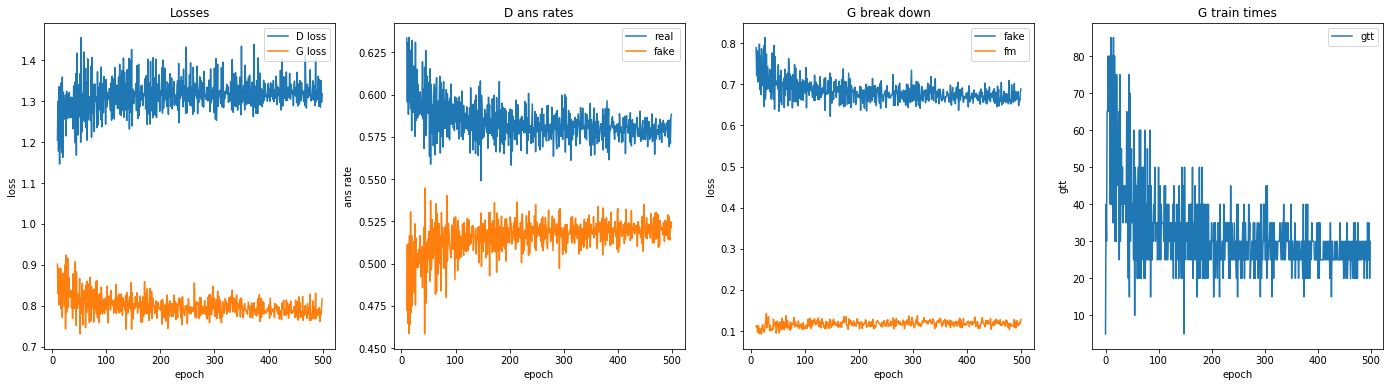

In [11]:
show_status_graph_gan_adaptive(status_dict, holizon=True, burn_in=10)

生成チェック

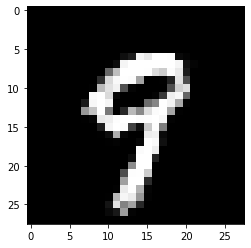

In [43]:
z = torch.randn(config.batch_size, config.latent_dim).to(device)
g_out = G_trained(z)
show_img(g_out.cpu(), 0)

ぶっこわれてるやつも出てくるけど，ちゃんとしたやつは割とキレイ  
モード崩壊も控えめっぽい

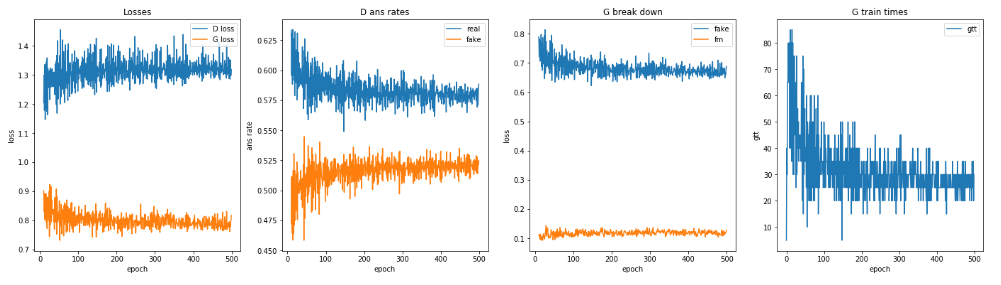

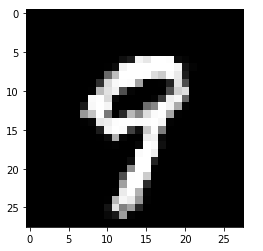